# Information Plane Analysis of Deep Neural Networks via Matrix-Based Renyi's Entropy and Tensor Kernels

In [1]:
from tqdm import tqdm
import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader
import torchvision
from torchvision.transforms import Compose, ToTensor

project_dir = os.path.split(os.getcwd())[0]
if project_dir not in sys.path:
    sys.path.append(project_dir)

from IPDL import TensorKernel
from models import MLP
from utils import moving_average, showMutualInformation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

## Matrix-Based Mutual Information

Rényi’s $\alpha$-order entropy is a generalization of Shannon’s entropy. For a random variable $X$ with probability density function (PDF) $f(x)$ over a finite set $\chi$, Rényi’s $\alpha$-order entropy is defined as

\begin{align}
\ H_{\alpha} f(x) = \frac{1}{1- \alpha} log \int_{\chi} f^{\alpha}(x) dx
\end{align}

Equation 1 has been widely applied in machine learning (Principe, 2010), and the particular case of $\alpha= 2$, combined with Parzen window density estimation. However,accurately estimating PDFs in high-dimensional data, which is typically the case for DNNs (Deep Neural Networks), is a challenging task. To avoid the problem of high-dimensional PDF estimation, Giraldo et al. \[3\] proposed a non-parametric framework for estimating entropy directly from data using infinitely divisible kernels with similar properties as Rényi’s $\alpha$-order entropy

**Definition**: let $x_i \in \mathcal{X} , \ i=1,2, ..., N$ denote data points and let $k : \mathcal{X} \times \mathcal{X} \rightarrow \mathbb{R}$ be an divisible positive definite kernel. Given the kernel matrix $K \in \mathbb{R}^{N \times N}$ with elements $(K)_{ij} = k(x_i, x_j)$ and the matrix $A$, $(A)_{ij}= \frac{1}{N} \frac{(K)_{ij}}{\sqrt{(K)_{ii} (K)_{jj}}}$, the matrix-based Rényi's $\alpha$-order entropy is given by

\begin{align}
\ S_{\alpha} = \frac{1}{1-\alpha} \log_{2} \left( tr(A^{\alpha})\right) = \frac{1}{1-\alpha} \left[ \sum_{i=1}^{N} \lambda_i (A)^\alpha \right]
\end{align}

where $tr(.)$ denotes the trace and $\lambda_i(A)$ denotes the $i^{th}$ eigenvalue of A.

The matrix–based Renyi’s entropy shown in previous equation have the same functional form of the statistical quantity in a Reproducing Kernel Hilbert Space (RKHS). Essentially, It is projecting marginal distribution to an RKHS to measure entropy and mutual information.

In addtion to the definition of matrix based entropy, Giraldo et al. \[3\] define the **joint entropy** between $x \in \mathcal{X}$ and $y \in \mathcal{Y}$ as

\begin{align}
\ S_\alpha(A_{\mathcal{X}}, A_{\mathcal{Y}}) =  S_\alpha \left( \frac{A_{\mathcal{X}} \circ A_{\mathcal{Y}}}{tr(A_{\mathcal{X}} \circ A_{\mathcal{Y}}) } \right)
\end{align}

where $x_i$ and $y_i$ are two different representations of the same object and $\circ$ denotes the Hadamard product, an element-wise product. Finally, the **Mutual Information (MI)** is defined as 

\begin{align}
\ I_\alpha (A_{\mathcal{X}}, A_{\mathcal{Y}}) = S_\alpha (A_{\mathcal{X}}) + S_\alpha (A_{\mathcal{Y}}) - S_\alpha (A_{\mathcal{X}}, A_{\mathcal{Y}})
\end{align}

As we can see, this definition of MI is similar to Shannon's formulation.

# Tensor-Based Mutual Information

The output of a convolutional layer is represented as a tensor $\mathbb{X}_i \in \mathbb{R}^C \otimes \mathbb{R}^H \otimes \mathbb{R}^W$ for a data point *i*, where $H$ and $W$ represents the spacial dimensional of the convolutions and $C$ the number of filters, or *channels*. Wickstrom *et al.* \[1\] propose to utilize tensor kernels \[2\] to produce a kernel matrix, $\textbf{K} \in \mathbb{R}^{N \times N}$, for the output of a convolutional layer. The ***radial basis function* (RBF) kernel** is represented as

\begin{align}
\ k_{ten}(X_i, X_j) = e^{-\frac{1}{\sigma^2} || X_i - X_j ||_{F}^{2}}
\end{align}

where $|| . ||_{F}$ denotes the Frobenius norm and $\sigma$ is the kernel width parameter.

In practice, the tensor in previous equation is computed by reshaping the tensor into a vectorized representation, $\mathbb{X}^{C \times W \times H}$, and replacing the Frobenius norm with a Euclidean norm.

This tensor-based approach is posible to estimate entropy and MI in Deep Neural Networks (DNN). This estimation can be done replacing the matrix A with

\begin{align}
\ (A_{ten})_{ij} = \frac{1}{N} \frac{(K_{ten})_{ij}}{\sqrt{(K_{ten})_{ii} (K_{ten})_{jj}}} 
\ = \frac{1}{N} k_{ten}(X_i, X_j)
\end{align}

## Chosing the Kernel Width

As we can see in *RBF Kernel*, $\sigma$ represents the kernel width parameter and it is always critical setting. Wickstrom et al.  choose $\sigma$ using a optimality criterion which is proposed by them \[1\]. A good kernel matrix should reveal the class structures present in the data. This can be accomplished by maximizing the so–called kernel alignment loss \[4\] between the kernel matrix of a given layer,$K_\sigma$, and the label kernel matrix, $K_y$

The kernel alignment loss is defined as:

\begin{align}
\ A(K_a, K_b) = \frac{\left< K_a, K_b  \right>_F}{||K_a||_F ||K_b||_F} 
\end{align}

where $|| . ||_F$ and $\left< . \right>$ denotes the Frobenius norm and inner product, respectively. Thus, they choose the optimal $\sigma$ as

\begin{align}
\sigma^* = arg \ max_\sigma \ A(K_\sigma, K_y)
\end{align}

To stabilize the $\sigma$ values across mini batches, we employ an exponential moving average, such that in layer $l$ at iterationt $t$ , they have

\begin{align}
\sigma_{l,t} = \beta \sigma_{l,t-1} + (1-\beta) \sigma_{l,t}^*
\end{align}

where $\beta \in [0,1]$ and $\sigma_{l,1} = \sigma_{l,1}^* $ 

# Mutual Information test using a Multi-Layer Perceptron

In [2]:
from torch.nn.functional import one_hot

net = MLP().to(device)

transformToTensor = Compose([ ToTensor() ])
dataset = torchvision.datasets.MNIST("../datasets/MNIST/", train=True, download=True, transform=transformToTensor)
train_set, val_set = torch.utils.data.random_split(dataset, [59850 , 150])
dataloader = DataLoader(train_set, batch_size=120, shuffle=True, num_workers=0)
dataloader_2 = DataLoader(val_set, batch_size=50, shuffle=False, num_workers=0)

val_inputs, val_labels = next(iter(dataloader_2))
val_inputs = val_inputs.flatten(1).to(device)
val_labels = one_hot(val_labels, num_classes=10).float().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.009, momentum=0.9)
# optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

loss_record = []

for epoch in range(1):  # loop over the dataset multiple times
    running_loss = 0.0
    i = 0

    with torch.no_grad():
        net.eval()
        net(val_inputs, val_labels)
        
    for inputs, labels in tqdm(dataloader):
        inputs = inputs.flatten(1).to(device)
        labels = labels.to(device)

        net.train()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)

        loss = criterion(outputs, labels)

        # print statistics
        running_loss += loss.item()
        if (i+1) % 50 == 0:
            loss_record.append(running_loss / 50)
            running_loss = 0.0

        loss.backward()
        optimizer.step()

        with torch.no_grad():
            net.eval()
            net(val_inputs, val_labels)

        if i > 500:
            for ip in net.getInformationPlaneLayers():
                ip.setNumberOfSigma(100)

        i += 1
 
print('Finished Training')

100%|██████████| 499/499 [02:42<00:00,  3.07it/s]Finished Training



In [ ]:
showMutualInformation(net.getInformationPlaneLayers(), colors=['Reds', 'Blues', 'binary', 'Oranges', 'Greens'])

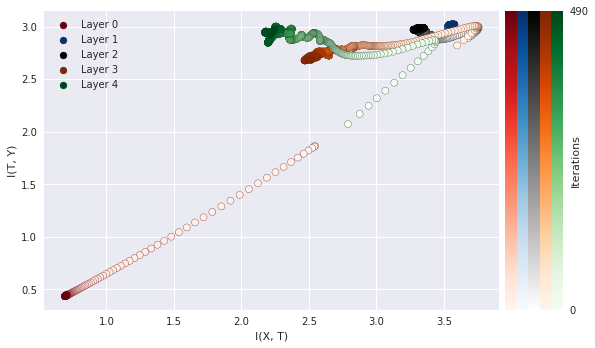

In [3]:
showMutualInformation(net.getInformationPlaneLayers(), colors=['Reds', 'Blues', 'binary', 'Oranges', 'Greens'])

In [4]:
ips = net.getInformationPlaneLayers()

No handles with labels found to put in legend.


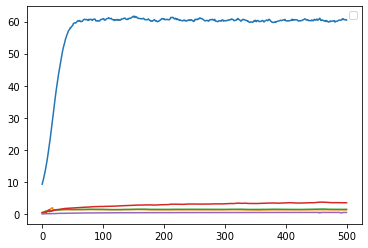

In [5]:
from matplotlib import pyplot as plt
for ip in ips:
    plt.plot(ip.sigma_optimizer.sigma_tmp)

plt.legend()
plt.show()

# References

\[1\] Wickstrøm, K., Løkse, S., Kampffmeyer, M., Yu, S., Principe, J., & Jenssen, R. (2019). Information Plane Analysis of Deep Neural Networks via Matrix-Based Renyi's Entropy and Tensor Kernels. arXiv preprint arXiv:1909.11396.

\[2\] Marco Signoretto, Lieven De Lathauwer, and Johan AK Suykens.   A kernel-based framework to tensorial data analysis.Neural networks , 24(8):861–874, 2011

\[3\] Luis Gonzalo Sanchez Giraldo, Murali Rao, and Jos ́e Carlos Príncipe.  Measures of entropy from data using infinitely divisible kernels.IEEE Transactions on Information Theory , 61:535–548, 2012

\[4\] Nello Cristianini, John Shawe-Taylor, Andre Elisseeff, and Jaz S Kandola.  On kernel-target align-ment. InAdvances in neural information processing systems , pp. 367–373, 2002